In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout, Bidirectional
from sklearn.utils import class_weight
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import (accuracy_score, recall_score, precision_score, f1_score, fbeta_score,
                             confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve,
                             classification_report) 

##### **Load Train and Test Data**

In [2]:
def load_and_prepare_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    x = list(data['review_text'].values())
    y = np.array([1 if label else 0 for label in data['is_spoiler'].values()], dtype = np.int32)
    return x, y

In [3]:
x_train, y_train = load_and_prepare_data('../data/processed/IMDB_reviews_train_cleaned.json')
x_test, y_test = load_and_prepare_data('../data/processed/IMDB_reviews_test.json')

##### **Sequence Padding**

In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

Max Words

In [5]:
vocab_size = len(tokenizer.word_index)
max_words = int(vocab_size * 0.10)         # Keep top 10%
print("Suggested max_words:", round(max_words, -4))

Suggested max_words: 20000


Max Length

In [6]:
lengths = [len(seq) for seq in x_train_seq]
percentiles = np.percentile(lengths, [50, 75, 90, 95, 99])
print("Suggested max_len:", round(int(percentiles[2]), -2))  # Between 90 - 95 percentile


Suggested max_len: 400


**_Testing: change to percentiles[3]_**

In [7]:
max_words = 20000      # Vocabulary size
max_len = 400          # Max sequence length 

In [8]:
tokenizer = Tokenizer(num_words = max_words, oov_token = "<OOV>")
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

In [9]:
x_train = pad_sequences(x_train_seq, maxlen = max_len, padding = 'post', truncating = 'post')
x_test = pad_sequences(x_test_seq, maxlen = max_len, padding = 'post', truncating = 'post')

##### **Simple RNN**

In [14]:
simple_rnn = Sequential()
simple_rnn.add(Embedding(max_words, 128))  # Embedding Layer
simple_rnn.add(SimpleRNN(128, activation = 'relu'))                # Simple RNN
simple_rnn.add(Dense(1, activation = "sigmoid"))                   # Output Layer

In [15]:
simple_rnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [16]:
simple_rnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
classes = np.unique(y_train)
class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = classes,
    y = y_train
)
class_weights_dict = dict(zip(classes, class_weights))

In [18]:
simple_rnn_history = simple_rnn.fit(
    x_train, y_train,
    validation_split = 0.2,
    epochs = 10,
    batch_size = 64,
    verbose = 1,
    class_weight = class_weights_dict
)

Epoch 1/10
5740/5740 ━━━━━━━━━━━━━━━━━━━━ 3791s 660ms/step - accuracy: 0.7042 - loss: 0.6837 - val_accuracy: 0.7315 - val_loss: 0.6750
Epoch 2/10
5740/5740 ━━━━━━━━━━━━━━━━━━━━ 1912s 333ms/step - accuracy: 0.7353 - loss: 0.6773 - val_accuracy: 0.7358 - val_loss: 0.6677
Epoch 3/10
5740/5740 ━━━━━━━━━━━━━━━━━━━━ 1317s 229ms/step - accuracy: 0.7410 - loss: 0.6673 - val_accuracy: 0.7350 - val_loss: 0.6932
Epoch 4/10
5740/5740 ━━━━━━━━━━━━━━━━━━━━ 1289s 225ms/step - accuracy: 0.7426 - loss: 42.9511 - val_accuracy: 0.7351 - val_loss: 0.6871
Epoch 5/10
5740/5740 ━━━━━━━━━━━━━━━━━━━━ 1254s 219ms/step - accuracy: 0.7481 - loss: 0.6487 - val_accuracy: 0.7357 - val_loss: 0.7209
Epoch 6/10
5740/5740 ━━━━━━━━━━━━━━━━━━━━ 1283s 224ms/step - accuracy: 0.7460 - loss: 0.6418 - val_accuracy: 0.7367 - val_loss: 0.7378
Epoch 7/10
5740/5740 ━━━━━━━━━━━━━━━━━━━━ 1239s 216ms/step - accuracy: 0.7332 - loss: 0.6380 - val_accuracy: 0.7358 - val_loss: 0.7422
Epoch 8/10
5740/5740 ━━━━━━━━━━━━━━━━━━━━ 1249s 218ms/

3587/3587 ━━━━━━━━━━━━━━━━━━━━ 64s 18ms/step
Accuracy: 0.7207750344130612
Recall: 0.21805962203886078
Precision: 0.4339822540060919
F1 Score: 0.2902697196510031
F2 Score: 0.24215597889540813
Confusion Matrix:
 [[76178  8548]
 [23502  6554]]


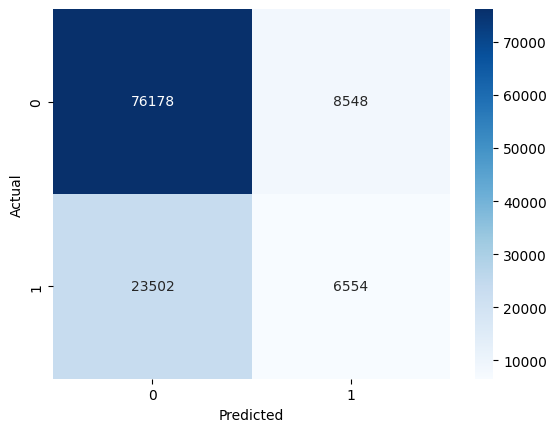

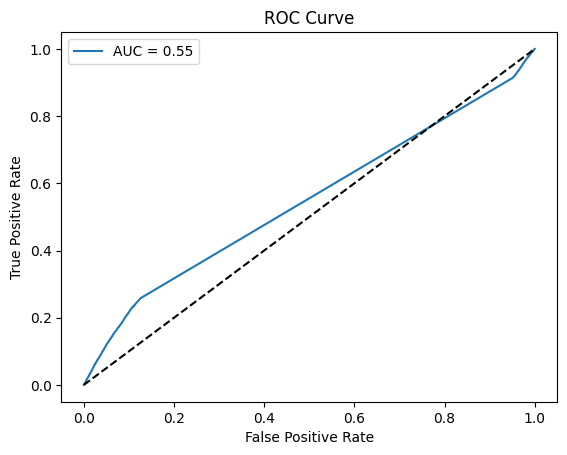

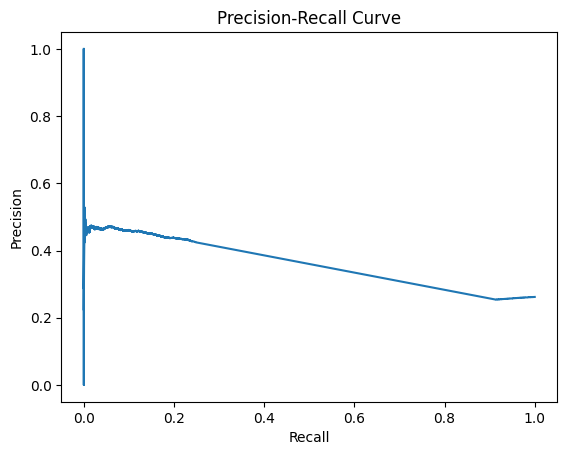

              precision    recall  f1-score   support

 Not Spoiler       0.76      0.90      0.83     84726
     Spoiler       0.43      0.22      0.29     30056

    accuracy                           0.72    114782
   macro avg       0.60      0.56      0.56    114782
weighted avg       0.68      0.72      0.69    114782



In [19]:
# Predict raw probabilities
y_pred_prob = simple_rnn.predict(x_test, verbose = 1).flatten()

# Convert probabilities to binary class labels
y_pred = (y_pred_prob > 0.5).astype(int)

# 1️⃣ Accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

# 2️⃣ Recall 
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# 3️⃣ Precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# 4️⃣ F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# 5️⃣ F2 score (more weight on recall)
f2 = fbeta_score(y_test, y_pred, beta=2)
print("F2 Score:", f2)

# 6️⃣ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix nicely
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 7️⃣ ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.plot(fpr, tpr, label = f"AUC = {auc:.2f}")
plt.plot([0,1],[0,1],'k--')  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# 8️⃣ Precision-Recall Curve
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

# 9️⃣ Classification Report
report = classification_report(y_test, y_pred, target_names = ['Not Spoiler', 'Spoiler'])
print(report)

##### **LSTM**

In [10]:
lstm_model = Sequential([
    Embedding(input_dim = max_words, output_dim = 128),
    LSTM(128, dropout = 0.2, recurrent_dropout = 0.2),
    Dense(1, activation = 'sigmoid')  # binary classification
])

In [11]:
lstm_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [12]:
lstm_model.build(input_shape=(None, max_len))
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 400, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,691,713 (10.27 MB)

 Trainable params: 2,691,713 (10.27 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
classes = np.unique(y_train)
class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = classes,
    y = y_train
)
class_weights_dict = dict(zip(classes, class_weights))

In [14]:
lstm_model_history = lstm_model.fit(
    x_train, y_train,
    validation_split = 0.2,
    epochs = 10,
    batch_size = 64,
    verbose = 1,
    class_weight = class_weights_dict
)

Epoch 1/10
5740/5740 ━━━━━━━━━━━━━━━━━━━━ 13050s 2s/step - accuracy: 0.6382 - loss: 0.6611 - val_accuracy: 0.6849 - val_loss: 0.5849
Epoch 2/10
5740/5740 ━━━━━━━━━━━━━━━━━━━━ 12209s 2s/step - accuracy: 0.7029 - loss: 0.5707 - val_accuracy: 0.7300 - val_loss: 0.5401
Epoch 3/10
5740/5740 ━━━━━━━━━━━━━━━━━━━━ 12283s 2s/step - accuracy: 0.7311 - loss: 0.5379 - val_accuracy: 0.7026 - val_loss: 0.5671
Epoch 4/10
5740/5740 ━━━━━━━━━━━━━━━━━━━━ 11362s 2s/step - accuracy: 0.7472 - loss: 0.5124 - val_accuracy: 0.7042 - val_loss: 0.5644
Epoch 5/10
5740/5740 ━━━━━━━━━━━━━━━━━━━━ 9708s 2s/step - accuracy: 0.7636 - loss: 0.4870 - val_accuracy: 0.7065 - val_loss: 0.5806
Epoch 6/10
5740/5740 ━━━━━━━━━━━━━━━━━━━━ 9742s 2s/step - accuracy: 0.7790 - loss: 0.4610 - val_accuracy: 0.7119 - val_loss: 0.5714
Epoch 7/10
5740/5740 ━━━━━━━━━━━━━━━━━━━━ 9737s 2s/step - accuracy: 0.7940 - loss: 0.4351 - val_accuracy: 0.7158 - val_loss: 0.5822
Epoch 8/10
5740/5740 ━━━━━━━━━━━━━━━━━━━━ 9841s 2s/step - accuracy: 0.80

3587/3587 ━━━━━━━━━━━━━━━━━━━━ 234s 65ms/step
Accuracy: 0.6168475893432768
Recall: 0.7093092893265903
Precision: 0.37692049291914925
F1 Score: 0.4922590253645358
F2 Score: 0.6029640523800096
Confusion Matrix:
 [[49484 35242]
 [ 8737 21319]]


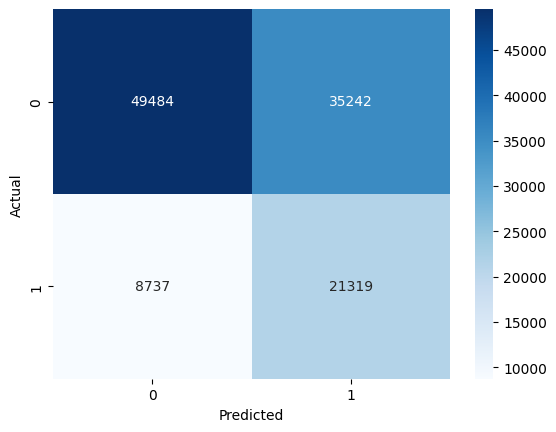

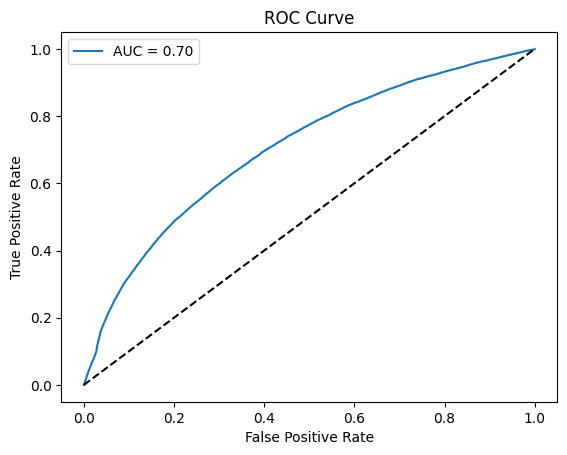

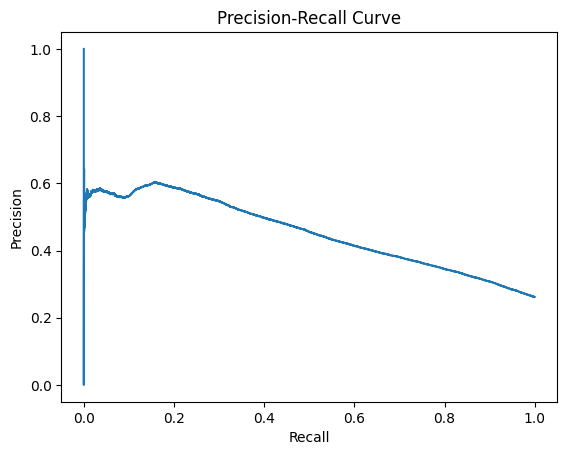

              precision    recall  f1-score   support

 Not Spoiler       0.85      0.58      0.69     84726
     Spoiler       0.38      0.71      0.49     30056

    accuracy                           0.62    114782
   macro avg       0.61      0.65      0.59    114782
weighted avg       0.73      0.62      0.64    114782



In [15]:
# Predict raw probabilities
y_pred_prob = lstm_model.predict(x_test, verbose = 1).flatten()

# Convert probabilities to binary class labels
y_pred = (y_pred_prob > 0.5).astype(int)

# 1️⃣ Accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

# 2️⃣ Recall 
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# 3️⃣ Precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# 4️⃣ F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# 5️⃣ F2 score (more weight on recall)
f2 = fbeta_score(y_test, y_pred, beta=2)
print("F2 Score:", f2)

# 6️⃣ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix nicely
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 7️⃣ ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.plot(fpr, tpr, label = f"AUC = {auc:.2f}")
plt.plot([0,1],[0,1],'k--')  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# 8️⃣ Precision-Recall Curve
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

# 9️⃣ Classification Report
report = classification_report(y_test, y_pred, target_names = ['Not Spoiler', 'Spoiler'])
print(report)